In [ ]:
#Standard Imports

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#import raw data and perform relevant transformations

In [123]:
raw_data = pd.read_csv("C:/Users/austi/Desktop/Catan R/rawplayer0919.csv",encoding='cp1252')

raw_data.fillna(0,inplace=True)

cols = [i for i in raw_data.columns if i not in ['Player']]
for col in cols:
    raw_data[col] = pd.to_numeric(raw_data[col])

In [124]:
game_data=pd.read_csv("C:/Users/austi/Desktop/Catan R/rawgamelog0919.csv",encoding='cp1252')

pd.to_datetime(game_data.Date,errors='coerce')

mean_duration = np.mean(game_data.Hours.dropna())

game_data.Hours.fillna(mean_duration,inplace=True)

game_data.fillna(0,inplace=True)


In [126]:
full_data =pd.merge(game_data,raw_data,left_on='Game ID',right_on='Game ID')    

In [127]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573 entries, 0 to 572
Data columns (total 28 columns):
Game ID                  573 non-null int64
Date                     573 non-null object
Location                 573 non-null object
Duration                 573 non-null object
Hours                    573 non-null float64
# Players                573 non-null int64
Winner                   573 non-null object
Qualified Game?          573 non-null int64
Win Type                 573 non-null object
Fish?                    573 non-null float64
Harbormaster?            573 non-null float64
Camels?                  573 non-null float64
Barbarians?              573 non-null float64
Cities&Knights           573 non-null float64
Notes                    573 non-null object
High Key Rating, 1-10    573 non-null float64
Player                   573 non-null object
Result                   573 non-null int64
Score                    573 non-null float64
Longest Road?            573 non-nul

In [136]:
no_fish = full_data['Fish?']==0
no_barb = full_data['Barbarians?']==0
no_cam = full_data['Camels?']==0
no_ck = full_data['Cities&Knights']==0
no_harb = full_data['Harbormaster?']==0
qual = full_data['Qualified Game?']==1

In [137]:
#filter to vanilla games
van_games = full_data[no_fish&no_barb&no_cam&no_ck&no_harb&qual]

In [140]:
#only numeric data for analysis
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
van_games_num = van_games.select_dtypes(include=numerics)

In [ ]:
#EDA

Result    0.333333
dtype: float64

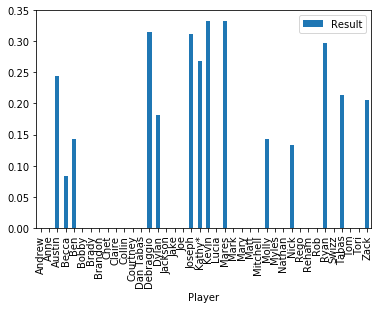

In [129]:
player_result_percentage = full_data.pivot_table(values='Result',index='Player',aggfunc=np.mean)

player_result_percentage.plot(kind='bar')

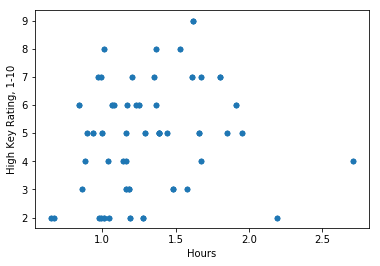

In [143]:
full_data[full_data['High Key Rating, 1-10']!=0].plot(kind='scatter',x='Hours', y='High Key Rating, 1-10')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C515861C50>]],
      dtype=object)

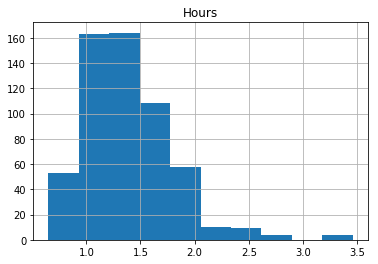

In [133]:
full_data.hist('Hours')

In [ ]:
#ML Imports

In [225]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [210]:
X = van_games_num.drop(['Score','Result','Game ID','Hours','# Players','High Key Rating, 1-10'],axis=1).values

In [211]:
y= van_games_num.Result.values

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=18)

In [213]:
rfc = RandomForestClassifier(n_estimators = 500,criterion = 'gini', min_samples_leaf = 0.05)

In [226]:
scaler = StandardScaler()

In [228]:
pipeline = make_pipeline(scaler,rfc)

In [229]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [231]:
y_pred = pipeline.predict(X_test)

In [232]:
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.7558139534883721


In [233]:
features_importances = pd.DataFrame(rfc.feature_importances_,index=van_games_num.drop(['Score','Result','Game ID','Hours','# Players','High Key Rating, 1-10'],axis=1).columns,columns=['importance']).sort_values('importance',ascending=False)
print(features_importances.sort_values('importance',ascending=False))

                 importance
Longest Road?      0.318693
First Mover?       0.238655
Dev Cards          0.128940
Largest Army?      0.089633
Order              0.063594
>2 Beers?          0.020485
Qualified Game?    0.000000
Fish?              0.000000
Harbormaster?      0.000000
Camels?            0.000000
Barbarians?        0.000000
Cities&Knights     0.000000
Began on SFV?      0.000000
Boot               0.000000
Prisoners          0.000000


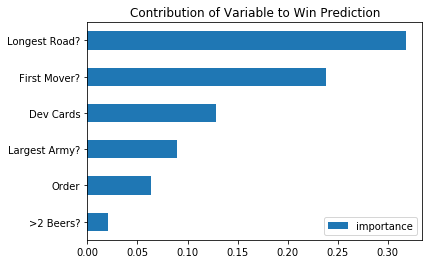

In [234]:
features_importances[0:6].sort_values('importance',ascending=True).plot(kind='barh',title='Contribution of Variable to Win Prediction')